<center>
<h1>Mustererkennung und Machine Learning</h1>

<h3> Wintersemester 2017/2018, 7th Exercise Sheet</h3>
<h4>Konstantin Jaehne, Luis Herrmann; Dozent: Raúl Rojas</h4>

<hr style='height:1px'>
</center>

# Exercise 1

In [66]:
%matplotlib inline
import sys
import numpy as np
import numpy.random as nprd
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

folderpath = '../'
filename = 'spambase.data'
data = pd.read_csv(folderpath+filename, header=None).as_matrix()

spam = []
nospam = []
for sample in data:
    if(sample[57] == 1):
        spam.append(sample[:57])
    elif(sample[57] == 0):
        nospam.append(sample[:57])
print('Data contains ' + str(len(spam)) + ' data points of spam and ' + str(len(nospam)) + ' points of non-spam.')
rd_nospam = nprd.permutation(nospam)
rd_spam = nprd.permutation(spam)
train = (rd_nospam[:int(0.8 * len(nospam))], rd_spam[:int(0.8 * len(spam))])
test = (rd_nospam[int(0.8 * len(nospam)):], rd_spam[int(0.8 * len(spam)):])

Data contains 1813 data points of spam and 2788 points of non-spam.


In [129]:
class LogisticClassifier:
    def __init__(self, data=None, labels=None, itlimit=1000, tol=1e-19):
        """
        data:
            Type: List/Tuple
            A list/tuple (l1,l2), where l1 and l2 are lists containing vectors assigned to class 1 and 2, respectively.
        labels (optinal):
            Type: List/Tuple
            A list/tuple (i1,i2) of two printable identifiers associated with each class
        itlimit (optional):
            Type: Integer
            Maximum number of iterations, before training is forcefully terminated.
        tol (otpinal)
            Type: Float
            Minimum rate of improvement that is acceptable. If improvement drops below tolerance, stop descent.
        """
        if(not(labels is None)):
            if(len(labels) == 2):
                self.labels = labels
            else:
                raise Exception('You must provide exactly two labels!')
        else:
            self.labels = (1, 0)
        if(not(data is None)):
            if(len(data) != 2):
                raise Exception('Data does not follow specified format!')
            if(len(data[0]) == 0 or len(data[1]) == 0):
                raise Exception('Data lists must contain at least one sample!')
            self.train(data, itlimit, tol)
    
    def train(self, data, itlimit=1000, tol=1e-19):
        Plen, Nlen = len(data[0]), len(data[1])
        self.x = np.vstack(data)
        #Calculate the variance for all features and set to 1 if zero. This will lead to no normalization.
        self.variance = np.var(self.x, axis=0)[np.newaxis,:]
        self.variance[np.where(self.variance == 0)] = 1
        #Calculate the mean for all features
        self.mean = np.mean(self.x, axis=0)[np.newaxis,:]
        #Normalize data
        self.x = self.normalize(self.x)
        #Add column of 1s
        self.x = np.hstack([np.ones(Plen+Nlen)[:,np.newaxis], self.x])
        self.y = np.append(np.repeat(1.0, Plen), np.repeat(-1.0, Nlen))
        #self.y = np.append(np.repeat(1.0, Plen), np.repeat(0.0, Nlen))
        #self.w = self.x[rd.randint(0, self.x.shape[1]-1)]
        self.w = nprd.random(self.x.shape[1])
        stepsize = 1e+1
        t = 0
        while(t < itlimit):
            weights = self.y * self.sigmoid(np.multiply(-self.y, np.dot(self.x, self.w)))
            #weights = self.y - self.sigmoid(np.dot(self.x, self.w))
            gradient =  np.sum(np.multiply(self.x, weights[:,np.newaxis]), axis=0)
            #Back-tracking: The measure for improvements is the avg of probabilitis rather than the likelihood function
            while(self.avgprob(self.w + stepsize * gradient) < self.avgprob(self.w + (stepsize / 2) * gradient)):
                stepsize /= 2
            #If the improvement drops below a certain tolerance, quit ascent
            if(self.avgprob(self.w + stepsize * gradient) - self.avgprob(self.w) < tol):
                break
            self.w += stepsize * gradient
            t += 1
            sys.stdout.write(str(t) + ' iterations, stepsize %.3e' % stepsize + '\r')
        sys.stdout.write('\nTraining complete!\n')
    
    def normalize(self, data):
        """Normalizes the data to allow for faster convergence of the gradient ascent"""
        return((data - self.mean) / self.variance)

    def classify(self, data):
        """Classifies a vector"""
        return(self.labels[int(self.prob(data) <= 0.5)])
    
    def prob(self, data):
        """Returns probabilities for a vector to be in the positive class"""
        return(self.sigmoid(np.dot(np.insert(self.normalize(data),0,1), self.w)))
    
    def avgprob(self, w):
        """Given a perceptron w, returns the average probability for the data to be in the positive class"""
        return(np.sum(self.sigmoid(np.multiply(self.y, np.dot(self.x, w))))/self.x.shape[0])
    
    def likelihood(self, w):
        """Given a perceptron w, returns the likelihood for the data to be in the positive class"""
        return(np.prod(self.sigmoid(np.multiply(self.y, np.dot(self.x, w)))))
    
    def sigmoid(self, x):
        """The sigmoidal functinon as defined by the numerically more stable tanh"""
        return(1/2 * (1 + np.tanh(1/2 * x)))

In [68]:
from IPython.display import display, HTML
def runtest(C, data_C0, data_C1):
    confusionMat = np.zeros([2, 2], dtype=int)
    for sample in data_C0:
        confusionMat[0, int(C.classify(sample) != C.labels[0])] += 1
    for sample in data_C1:
        confusionMat[1, int(C.classify(sample) == C.labels[1])] += 1
    print('-The confusion matrix is given by:')
    html = pd.DataFrame(confusionMat,index=C.labels, columns=C.labels).to_html()
    display(HTML(html))
    print('-The error rate is: ' + str(1-sum(np.diag(confusionMat))/(len(data_C0) + len(data_C1))) + '\n')

In [158]:
C = LogisticClassifier(train, labels=('No Spam', 'Spam'), itlimit=2000)
runtest(C, test[0], test[1])

12 iterations, stepsize 1.562e-01
Training complete!
-The confusion matrix is given by:


,No Spam,Spam
No Spam,498,60
Spam,37,326


-The error rate is: 0.105320304017



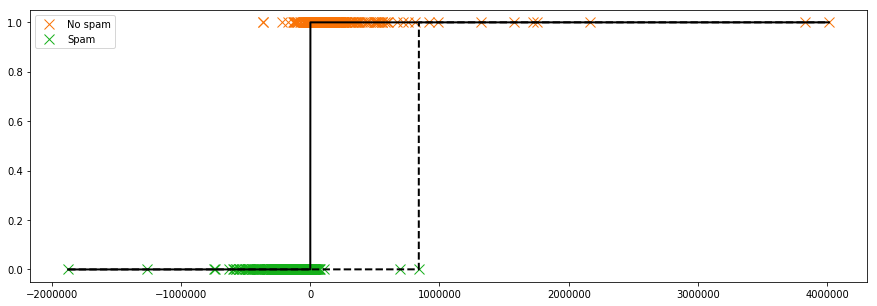

In [1154]:
plt.figure(figsize=(15, 5))
testvals = C.normalize(np.vstack(test))
projection = np.dot(np.hstack([np.repeat(1, len(testvals))[:,np.newaxis], testvals]), C.w)
xvals = np.arange(min(projection), max(projection))
plt.plot(projection[:len(test[0])], [1]*len(test[0]), 'x', markersize=10, color='xkcd:orange', label='No spam')
plt.plot(projection[len(test[0]):], [0]*len(test[1]), 'x', markersize=10, color='xkcd:green', label='Spam')
plt.plot(xvals, C.sigmoid(xvals), '-', linewidth=2.0, color='black')
plt.plot(xvals, C.sigmoid(xvals-max(projection[len(test[0]):])), '-', linestyle='dashed', linewidth=2.0, color='black')
plt.legend(loc='upper left')
plt.show()

As the simoid function can be shifted on the x-axis by introducing a scalar $x_0$ to compute $\text{sig}'(x) = \text{sig}(x-x_0)$, we can easily adjust the trained vector to give a certain class more importance. For instance, by shifting the sigmoid function to the right as in the above plot, we could exclude the possibility of classfying spam as non-spam (at least for the given test dataset), although also allowing for more non-spam to be wrongly classified as spam in the process. Note that this procedure does not require to repeat the training, but can simply be dynamically applied solely by introducing said shift.

In [94]:
folderpath = '../'
filename = 'iris.data'
data = pd.read_csv(folderpath+filename, header=None).as_matrix()
data_isetosa = []
data_iversicolor = []
data_ivirginica = []
for sample in data:
    if(sample[4] == 'Iris-setosa'):
        data_isetosa.append(np.insert(np.array(sample[0:4], dtype=float),0,1))
    elif(sample[4] == 'Iris-versicolor'):
        data_iversicolor.append(np.insert(np.array(sample[0:4], dtype=float),0,1))
    elif(sample[4] == 'Iris-virginica'):
        data_ivirginica.append(np.insert(np.array(sample[0:4], dtype=float),0,1))

rdindices = rd.sample(range(len(data_isetosa)), len(data_isetosa))
setosa_train = np.vstack(data_isetosa)[rdindices[:int(0.8*len(data_isetosa))]]
setosa_test = np.vstack(data_isetosa)[rdindices[int(0.8*len(data_isetosa)):]]

rdindices = rd.sample(range(len(data_iversicolor)), len(data_iversicolor))
versicolor_train = np.vstack(data_iversicolor)[rdindices[:int(0.8*len(data_isetosa))]]
versicolor_test = np.vstack(data_iversicolor)[rdindices[int(0.8*len(data_isetosa)):]]

rdindices = rd.sample(range(len(data_ivirginica)), len(data_ivirginica))
virginica_train = np.vstack(data_ivirginica)[rdindices[:int(0.8*len(data_isetosa))]]
virginica_test = np.vstack(data_ivirginica)[rdindices[int(0.8*len(data_isetosa)):]]

To have a point of comparison, we also applied the classifier to the Iris dataset from a past exercise sheet. We obtain a perfect classification even for the two classes that were not separable using the binary perceptron.

In [1140]:
C_setosa_versicolor = LogisticClassifier([setosa_train, versicolor_train], labels = ('Iris-setosa','Iris-versicolor'), itlimit=100)
C_setosa_virginica = LogisticClassifier([setosa_train, virginica_train], labels= ('Iris-setosa', 'Iris-virginica'), itlimit=100)
C_versicolor_virginica = LogisticClassifier([versicolor_train, virginica_train], ('Iris-versicolor','Iris-virginica'), itlimit=100)

1 iterations, stepsize 1e+01
Training complete!
1 iterations, stepsize 1e+01
Training complete!
4 iterations, stepsize 1e+01
Training complete!


In [1141]:
runtest(C_setosa_versicolor, setosa_test, versicolor_test)
runtest(C_setosa_virginica, setosa_test, virginica_test)
runtest(C_versicolor_virginica, versicolor_test, virginica_test)

-The confusion matrix is given by:


,Iris-setosa,Iris-versicolor
Iris-setosa,10,0
Iris-versicolor,0,10


-The error rate is: 0.0

-The confusion matrix is given by:


,Iris-setosa,Iris-virginica
Iris-setosa,10,0
Iris-virginica,0,10


-The error rate is: 0.0

-The confusion matrix is given by:


,Iris-versicolor,Iris-virginica
Iris-versicolor,10,0
Iris-virginica,0,10


-The error rate is: 0.0



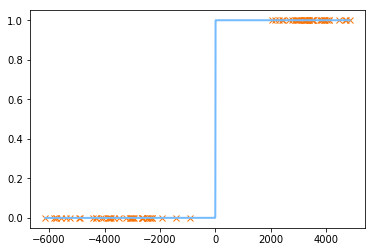

In [805]:
projection = np.dot(C_setosa_versicolor.x, C_setosa_versicolor.w)
xvals = np.arange(min(projection), max(projection))
plt.plot(projection, C_setosa_versicolor.sigmoid(projection), 'x', color='xkcd:orange')
plt.plot(xvals, C_setosa_versicolor.sigmoid(xvals), linewidth=2.0, color='xkcd:sky blue')
plt.show()

# Exercise 2

In [958]:
anddata = np.array([[1,1]]), np.array([[0,0],[0,1],[1,0]])
ordata = np.array([[1,1],[0,1],[1,0]]), np.array([[0,0]])
xordata = np.array([[0,1],[1,0]]), np.array([[0,0],[1,1]])

In [1038]:
Cand = LogisticClassifier(anddata, itlimit=500)
Cor = LogisticClassifier(ordata, itlimit=500)
Cxor = LogisticClassifier(xordata, itlimit=20000)

500 iterations, stepsize 1e+00
500 iterations, stepsize 1e-01
Training complete!
Training complete!

In [960]:
tuples = np.array([(i,j) for i in range(2) for j in range(2)]).reshape([4,2])
andvals = np.array([Cand.classify(x) for x in tuples])
orvals = np.array([Cor.classify(x) for x in tuples])
xorvals = np.array([Cxor.classify(x) for x in tuples])
html = pd.DataFrame(np.vstack([andvals, orvals, xorvals]).transpose(), 
                    index=map(str, tuples), 
                    columns=('and','or','xor')).to_html()
display(HTML(html))

,and,or,xor
[0 0],0,0,0
[0 1],0,1,0
[1 0],0,1,1
[1 1],1,1,1


Interistingly, the logistic regression for XOR does not succeed, even at high iteration numbers. This makes sense taking into account that in order for the logistic regression to work, we require the data classes to be separable, which is clearly not the case for XOR given boolean coordinates given the symmetry of the function:

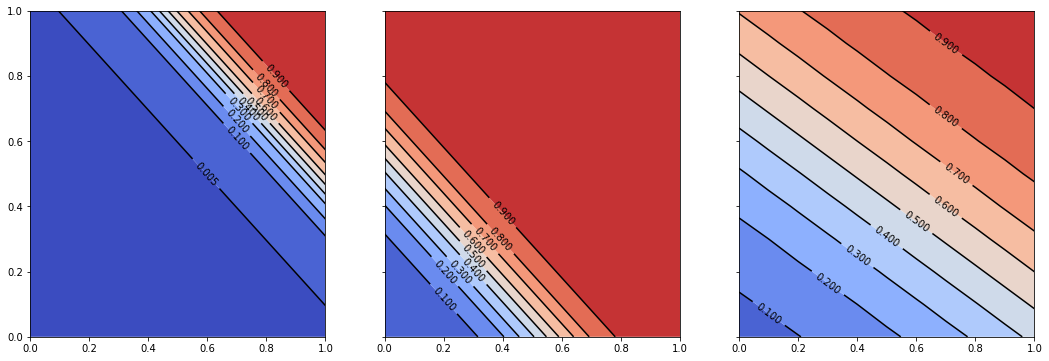

In [1079]:
x, y = np.arange(0, 1.5,1e-1), np.arange(0, 1.5,1e-1)
X, Y = np.meshgrid(x, y)
coordinates = list(zip(X.ravel(), Y.ravel()))
Zand = np.array([Cand.prob(x) for x in coordinates]).reshape(X.shape)
Zor = np.array([Cor.prob(x) for x in coordinates]).reshape(X.shape)
Zxor = np.array([Cxor.prob(x) for x in coordinates]).reshape(X.shape)
Z = (Zand, Zor, Zxor)
levels = [0, 5e-3] + list(np.arange(0.1, 1.1, 0.1))

fig, subplots = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
for i in range(len(subplots)):
    subplots[i].set_xlim(0,1)
    subplots[i].set_ylim(0,1)
    subplots[i].contourf(X, Y, Z[i], levels=levels, alpha=1, cmap=cm.coolwarm, antialiased=True)
    contour = subplots[i].contour(X, Y, Z[i], levels=levels, colors='black', alpha=1, antialiased=True)
    subplots[i].clabel(contour, inline=1, colors='black', alpha=1, fontsize=10)

plt.show()